# LLM Disease Prediction
This project aims to use a combination of different LLM methods from Gemini API & Ollama (object detection, classification, & text generation) to create a disease prediction pipeline, which first identifies diseased leaves, then identifies the plant and disease and finally provides information on how to deal with the disease and advice using trusted agronomy documents as a RAG.

## 1 - Library Imports
The first step is to import the required libraries for this project.

In [1]:
import kagglehub
import tensorflow_datasets as tfds
import os
import shutil
from google import genai
from google.genai import types
import json
from PIL import Image, ImageDraw
import ollama
import re
import numpy as np
from dotenv import load_dotenv
import pandas as pd
import random
from tabulate import tabulate
import matplotlib.pyplot as plt

## 2 - The Dataset
For the dataset, I used a combination of 3 different datasets. The first is the kaggle dataset for the training data.

In [4]:
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Path to dataset files:", path)

  1%|          | 33.0M/2.70G [00:04<05:42, 8.36MB/s]


KeyboardInterrupt: 

In [89]:
shutil.move(path, "/Users/mariamelantably/Desktop/programs/vais internship/disease_project")

'/Users/mariamelantably/Desktop/programs/vais internship/disease_project/2'

The second dataset used is the plant village dataset from tensorflow, used as testing data

In [90]:
builder = tfds.builder('plant_village', data_dir = "/Users/mariamelantably/Desktop/programs/vais internship/disease_project")
builder.download_and_prepare()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /Users/mariamelantably/Desktop/programs/vais internship/disease_project/plant_village/incomplete.USN…

Dataset plant_village downloaded and prepared to /Users/mariamelantably/Desktop/programs/vais internship/disease_project/plant_village/1.0.2. Subsequent calls will reuse this data.


In [92]:
shutil.move("/Users/mariamelantably/Desktop/programs/vais internship/disease_project/downloads/extracted/ZIP.data.mend.com_publ-file_data_tywb_file_d565-c1rDQyRTmE0CqGGXmH53WlQp0NWefMfDW89aj1A0m5D_A", "/Users/mariamelantably/Desktop/programs/vais internship/disease_project/2/test/test")

Error: Destination path '/Users/mariamelantably/Desktop/programs/vais internship/disease_project/2/test/test/ZIP.data.mend.com_publ-file_data_tywb_file_d565-c1rDQyRTmE0CqGGXmH53WlQp0NWefMfDW89aj1A0m5D_A' already exists

These two datasets are very large, and so they must be reduced down by random samples, as done below to make our ammended dataset

In [2]:
names = os.listdir("dataset_disease/test")
names.remove(".DS_Store")

In [79]:
for cl in names:
    os.mkdir(f'ammended_dataset/preprocessed/test/{cl}')
    os.mkdir(f'ammended_dataset/preprocessed/train/{cl}')
    os.mkdir(f'ammended_dataset/processed/test/{cl}')
    os.mkdir(f'ammended_dataset/processed/train/{cl}')
    x = os.listdir(f'dataset_disease/test/{cl}')
    y = os.listdir(f'dataset_disease/train/{cl}')
    random_x = random.sample(x, 10)
    random_y = random.sample(y, 10)
    for img in random_x:
        shutil.copyfile(f'dataset_disease/test/{cl}/{img}', f'ammended_dataset/preprocessed/test/{cl}')
    for img in random_y:
        shutil.copyfile(f'dataset_disease/train/{cl}/{img}', f'ammended_dataset/preprocessed/train/{cl}')

The next dataset used is from the following link: https://public.roboflow.com/object-detection/plantdoc/. This dataset consists of images and labels depicting where the leaves are in the images, which will be used as few-shot examples in the object detectiont ask.

In [5]:
with open("few_shot_examples/_annotations.coco.json", "r") as file:
    data = json.load(file)
examples = []
for x in data['images']:
    i = Image.open("few_shot_examples/unprocessed/"+x['file_name'])
    width, height = i.size
    draw = ImageDraw.Draw(i)
    box = [x['bbox'][0], x['bbox'][1], x['bbox'][0] + x['bbox'][2], x['bbox'][1] + x['bbox'][3]]
    draw.rectangle(box, outline = 'red', fill = None, width = 1)
    box = [box[0]/width*100, box[3]/height*100, box[2]/width*100, box[1]/height*100]
    examples.append(box)
    i.save(f"processed_{x['file_name']}")
    shutil.move(f"processed_{x['file_name']}", "/Users/mariamelantably/Desktop/programs/vais internship/disease_project/few_shot_examples/processed")
    

## 3 - Object Detection
The first step is to load the genai client using the API key from an environment variable.

In [3]:
load_dotenv("root.env")
API_KEY = os.getenv("GEMINI_API_KEY")
client = genai.Client(api_key = API_KEY)

Next, the two few-shot examples are uploaded into the gemini client. This will allow us to reference them in the prompt for the object detection and reuse them for each object.

In [7]:
image1 = client.files.upload(file = "few_shot_examples/processed/processed_Apple-Leaf-Wallpaper-17_jpg.rf.02b66598333655d0e2073c3408ebc0c9.jpg")
image2 = client.files.upload(file = "few_shot_examples/processed/processed_ed12ff77ce021883de241830dee55e2e53d2c93231699_1260x1260_jpg.rf.0349b32b542b5b783d138b1b4bfe8fe7.jpg")

The prompt is then loaded in from its text file. I used placeholders for the unique identifiers and the boxes for the two few shot images, and then inserted them here using replace.

In [8]:
GEN_BOX_PROMPT = open("disease_detection_prompt.txt").read()
GEN_BOX_PROMPT = GEN_BOX_PROMPT.replace('<img1uri>', image1.uri)
GEN_BOX_PROMPT = GEN_BOX_PROMPT.replace('<img2uri>', image2.uri)
GEN_BOX_PROMPT = GEN_BOX_PROMPT.replace('<img1box>', str(examples[0]))
GEN_BOX_PROMPT = GEN_BOX_PROMPT.replace('<img2box>', str(examples[1]))
print(GEN_BOX_PROMPT)

You are a helpful chatbot. I would like you to detect the leaf in the following image, with the following additional constraints, on every new image you receive:
Ensure that you return a box in the form box_2d = [xmin, ymax, xmax, ymin]. xmax should always be bigger than xmin and ymax should always be bigger than ymin. Please give the value as a percentage of the width (for xmin and xmax) and the percentage of the height (for ymin and ymax)

# Examples
I have included two examples for you, which are listed below with their URIs and the returned boxes:
- URI: https://generativelanguage.googleapis.com/v1beta/files/ywo5ij4awwo3, box_2d = [28.999999999999996, 99.25925925925927, 77.671875, 6.0]
- URI: https://generativelanguage.googleapis.com/v1beta/files/zd7zjseh5ije, box_2d = [26.0, 87.06349206349206, 77.60984848484848, 5.0]

If it appears that the leaf is the entire picture, just return the dimensions of the image (i.e. the entire image).

Please be as accurate as possible with these box

The next step is to create the object detection process, which consists of calling the client to generate a response in the form of a json, and then generating the bounding boxes and using them to crop the images, which are then saved into the destination folder. This code is then called on all the images in the train and test sets in the 'ammended_dataset' directory.

In [9]:
def process_image(file_n, move_dest):
  image_new = open(file_n, "rb").read()
  prompt = [
    types.Part.from_text(text = GEN_BOX_PROMPT),
    
    types.Part.from_bytes(data=image_new, mime_type="image/jpeg")
  ]
  config = types.GenerateContentConfig(response_mime_type="application/json")

  response = client.models.generate_content(
    contents = prompt,
    model="gemini-2.5-flash",
    config=config)
  im = Image.open(file_n)
  width, height = im.size
  bounding_boxes = json.loads(response.text)
  print(bounding_boxes)
  width, height = im.size
  try:
    xmin = int(bounding_boxes['box_2d'][0]/100 * width)
    ymax = int(bounding_boxes['box_2d'][1]/100 * height)
    xmax = int(bounding_boxes['box_2d'][2]/100 * width)
    ymin = int(bounding_boxes['box_2d'][3]/100 * height)
  except TypeError:
    xmin = int(bounding_boxes[0]/100 * width)
    ymax = int(bounding_boxes[1]/100 * height)
    xmax = int(bounding_boxes[2]/100 * width)
    ymin = int(bounding_boxes[3]/100 * height)
  y = im.crop([xmin, ymin, xmax, ymax])
  y.save(file_n)
  shutil.move(file_n, move_dest)
  print(file_n)
    

In [17]:
for cl in names:
    for case in ['test', 'train']:
        for img in os.listdir(f'ammended_dataset/preprocessed/{case}/{cl}'):
            process_image(f'ammended_dataset/preprocessed/{case}/{cl}/{img}', f'ammended_dataset/processed/{case}/{cl}')


{'box_2d': [6.640625, 97.65625, 96.875, 1.171875]}
ammended_dataset/preprocessed/train/Apple___Black_rot/7fb51374-f3ae-4dc9-8e0b-f25552528852___JR_FrgE.S 2894_90deg.JPG
{'box_2d': [6.8, 96.4, 96.0, 3.6]}
ammended_dataset/preprocessed/train/Apple___Black_rot/f58de461-853f-46d7-b223-d48a81507a85___JR_FrgE.S 2996_90deg.JPG
{'box_2d': [11.71875, 92.1875, 89.84375, 4.296875]}
ammended_dataset/preprocessed/train/Apple___Black_rot/a2d0df69-e2ee-4b7b-8b48-051027a83258___JR_FrgE.S 2936_new30degFlipLR.JPG
{'box_2d': [9.5, 94.5, 89.5, 5.5]}
ammended_dataset/preprocessed/test/Apple___healthy/image (691).JPG
{'box_2d': [7.0, 98.0, 94.5, 3.5]}
ammended_dataset/preprocessed/test/Apple___healthy/image (1432).JPG
{'box_2d': [0.0, 100.0, 100.0, 0.0]}
ammended_dataset/preprocessed/test/Apple___healthy/image (302).JPG
{'box_2d': [0.5, 99.5, 99.5, 0.5]}
ammended_dataset/preprocessed/test/Apple___healthy/image (837).JPG
{'box_2d': [17.0, 98.0, 81.0, 3.0]}
ammended_dataset/preprocessed/test/Apple___healthy/i

## 4 - Disease Classification

### Code
The first step is to create the training and testing datasets, which is used by first turning them into structured JSONs and then into a pandas dataframe. For analysis purposes, I have done this process on both the processed (object detected) data and the unprocessed data before the object detection process.

In [4]:
train_images = []
test_images = []
for cl in os.listdir("ammended_dataset/processed/train"):
    if (cl != '.DS_Store'):
        for img_path in os.listdir(f"ammended_dataset/processed/train/{cl}"):
            train_images.append(
                {
                    "image_path" : str(f"/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/train/{cl}/{img_path}"),
                    "class_id":f"class_{names.index(cl)}",
                    "class_name": cl
                }
            )

for cl in os.listdir("ammended_dataset/processed/test"):
    if (cl != '.DS_Store'):
        for img_path in os.listdir(f"ammended_dataset/processed/test/{cl}"):
            test_images.append(
                {
                    "image_path" : str(f"/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/{cl}/{img_path}"),
                    "class_id":f"class_{names.index(cl)}",
                    "class_name": cl
                }
            )

random.shuffle(test_images)
random.shuffle(train_images)
    

In [5]:
train_images_2 = []
test_images_2 = []
for cl in os.listdir("ammended_dataset/preprocessed/train"):
    if (cl != '.DS_Store'):
        for img_path in os.listdir(f"ammended_dataset/preprocessed/train/{cl}"):
            train_images_2.append(
                {
                    "image_path" : str(f"/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/preprocessed/train/{cl}/{img_path}"),
                    "class_id":f"class_{names.index(cl)}",
                    "class_name": cl
                }
            )

for cl in os.listdir("ammended_dataset/preprocessed/test"):
    if (cl != '.DS_Store'):
        for img_path in os.listdir(f"ammended_dataset/preprocessed/test/{cl}"):
            test_images_2.append(
                {
                    "image_path" : str(f"/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/preprocessed/test/{cl}/{img_path}"),
                    "class_id":f"class_{names.index(cl)}",
                    "class_name": cl
                }
            )

random.shuffle(test_images_2)
random.shuffle(train_images_2)

In [6]:
df_train = pd.DataFrame(train_images)
df_test = pd.DataFrame(test_images)
df_train_2 = pd.DataFrame(train_images_2)
df_test_2 = pd.DataFrame(test_images_2)

The next step involves creating the training message. This involves two steps, which are done once for training and once for testing:
- Import the images for training, with their labels, using the google types directory to convert images into their byte forms. 
- Import the images for testing,  without labels, with the image ids that are used to identify it later in the output.

In [7]:
messages_train = ['Possible labels:']
grouped = df_train.groupby('class_name')
for class_id, group in grouped:
    for _, row in group.iterrows():
        image_new = open(row["image_path"], "rb").read()
        base64_image = types.Part.from_bytes(data=image_new, mime_type="image/jpeg")
        messages_train.append(base64_image)
    print(f"{class_id} done")
    messages_train.append(f"label: {class_id}")

Apple___Apple_scab done
Apple___Black_rot done
Apple___Cedar_apple_rust done
Apple___healthy done
Blueberry___healthy done
Cherry___Powdery_mildew done
Cherry___healthy done
Corn___Cercospora_leaf_spot Gray_leaf_spot done
Corn___Common_rust done
Corn___Northern_Leaf_Blight done
Corn___healthy done
Grape___Black_rot done
Grape___Esca_Black_Measles done
Grape___Leaf_blight_Isariopsis_Leaf_Spot done
Grape___healthy done
Orange___Haunglongbing_Citrus_greening done
Peach___Bacterial_spot done
Peach___healthy done
Pepper_bell___Bacterial_spot done
Pepper_bell___healthy done
Potato___Early_blight done
Potato___Late_blight done
Potato___healthy done
Raspberry___healthy done
Soybean___healthy done
Squash___Powdery_mildew done
Strawberry___Leaf_scorch done
Strawberry___healthy done
Tomato___Bacterial_spot done
Tomato___Early_blight done
Tomato___Late_blight done
Tomato___Leaf_Mold done
Tomato___Septoria_leaf_spot done
Tomato___Spider_mites_Two_spotted_spider_mite done
Tomato___Target_Spot done
T

In [8]:
messages = ["Input images:"]
for i, image_path in enumerate(df_test.image_path):
    base64_img = open(image_path, "rb").read()
    image_message = [
        types.Part.from_bytes(data=base64_img, mime_type="image/jpeg"),
        f"input_image_id: {i}"
    ]
    messages.extend(image_message)
    print(f"{image_path} done")
messages.append(f"Please correctly classify all {df_train.shape[0]} images")

/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Tomato___Early_blight/image (286).JPG done
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Apple___Black_rot/image (617).JPG done
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Peach___healthy/image (44).JPG done
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Peach___healthy/image (211).JPG done
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Corn___Common_rust/image (868).JPG done
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Tomato___Early_blight/image (662).JPG done
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Tomato___Late_blight/image (119).J

In [9]:
messages_train_2 = ['Possible labels:']
grouped = df_train_2.groupby('class_name')
for class_id, group in grouped:
    for _, row in group.iterrows():
        image_new = open(row["image_path"], "rb").read()
        base64_image = types.Part.from_bytes(data=image_new, mime_type="image/jpeg")
        messages_train_2.append(base64_image)
    print(f"{class_id} done")
    messages_train_2.append(f"label: {class_id}")

messages_2 = ["Input images:"]
for i, image_path in enumerate(df_test_2.image_path):
    base64_img = open(image_path, "rb").read()
    image_message = [
        types.Part.from_bytes(data=base64_img, mime_type="image/jpeg"),
        f"input_image_id: {i}"
    ]
    messages_2.extend(image_message)
    print(f"{image_path} done")
messages_2.append(f"Please correctly classify all {df_train.shape[0]} images")

Apple___Apple_scab done
Apple___Black_rot done
Apple___Cedar_apple_rust done
Apple___healthy done
Blueberry___healthy done
Cherry___Powdery_mildew done
Cherry___healthy done
Corn___Cercospora_leaf_spot Gray_leaf_spot done
Corn___Common_rust done
Corn___Northern_Leaf_Blight done
Corn___healthy done
Grape___Black_rot done
Grape___Esca_Black_Measles done
Grape___Leaf_blight_Isariopsis_Leaf_Spot done
Grape___healthy done
Orange___Haunglongbing_Citrus_greening done
Peach___Bacterial_spot done
Peach___healthy done
Pepper_bell___Bacterial_spot done
Pepper_bell___healthy done
Potato___Early_blight done
Potato___Late_blight done
Potato___healthy done
Raspberry___healthy done
Soybean___healthy done
Squash___Powdery_mildew done
Strawberry___Leaf_scorch done
Strawberry___healthy done
Tomato___Bacterial_spot done
Tomato___Early_blight done
Tomato___Late_blight done
Tomato___Leaf_Mold done
Tomato___Septoria_leaf_spot done
Tomato___Spider_mites_Two_spotted_spider_mite done
Tomato___Target_Spot done
T

Then, the prompt is imported, which includes examples of how the data should be structured. The client is then called to make the responses and then the responses are loaded as a JSON.

In [45]:
client = genai.Client(api_key = API_KEY)
generation_config = types.GenerateContentConfig(response_mime_type="application/json", max_output_tokens=6000000)
CLASS_PROMPT = open("classification_prompt.txt").read()
response = client.models.generate_content(
    contents = [CLASS_PROMPT] + messages_train + messages,
    model="gemini-2.5-flash",
    config=generation_config
)
response2 = client.models.generate_content(
    contents = [CLASS_PROMPT] + messages_train_2 + messages_2,
    model="gemini-2.5-flash",
    config=generation_config
)

In [46]:
response_json_1 = json.loads(response.text)
response_json_2 = json.loads(response2.text)

### Analysis
We will then do some analysis of the results from the object classification. The first step is to create the following helper function, which converts the class names into a tuple of the name of the crop and the name of the disease.

In [12]:
def convert_format(cl):
    name = names[cl]
    match = re.search(r"^([\w|_,()|\s]+)(___)([\w|_,()|\s]+)$", name)
    crop = match.group(1)
    disease = match.group(3)
    crop = crop.lower()
    disease = disease.lower()
    disease = re.sub("_", " ", disease)
    if crop == "pepper,_bell":
        crop = "bell pepper"

    return (crop, disease)
    

The first step is to analyse how the accuracy changes for the preprocessed and processed data.

In [13]:
def get_accuracy(y_true, y_pred):
    total = len(y_true)
    correct = 0
    for i in range(total):
        if y_true[i] == y_pred[i]:
            correct += 1
    return correct/total

In [14]:
predictions_1 = [item['label'] for item in response_json_1['output']]
predictions_2 = [item['label'] for item in response_json_2['output']]
actual = list(df_test.class_name)
actual_2 = list(df_test_2.class_name)
accuracy = get_accuracy(actual, predictions)
accuracy_2 = get_accuracy(actual_2, predictions_2)
print("Processed data accuracy:", accuracy)
print("Unprocessed data accuracy:", accuracy_2)

Processed data accuracy: 0.7684210526315789
Unprocessed data accuracy: 0.7631578947368421


The next analysis is to look at the differences in predicting the crop and predicting the disease. 

In [15]:
def accuracy_analysis(y_true, y_pred):
    total = len(y_true)
    correct_crop = 0
    correct_disease = 0 
    for i in range(total):
        crop1, disease1 = convert_format(names.index(y_true[i]))
        crop2, disease2 = convert_format(names.index(y_pred[i]))
        if crop1 == crop2:
            correct_crop += 1
        if disease1 == disease2:
            correct_disease += 1
    return (correct_crop/total, correct_disease/total)

acc = accuracy_analysis(actual, predictions)
print("Accuracy of crop prediction:", acc[0])
print("Accuracy of disease prediction:", acc[1])

Accuracy of crop prediction: 0.95
Accuracy of disease prediction: 0.8026315789473685


Next, we will analyse the accuracy per crop and look at how this correlates with the number of sub-labels we have for each crop.

In [16]:
def accuracy_per_crop(y_true, y_pred):
    #first, parse the crop names into a dictionary
    dict = {}
    for c in names:
        crop, _ = convert_format(names.index(c))
        if crop not in dict.keys():
            dict[crop] = [0,0]
    for i in range(len(y_true)):
        crop1, disease1 = convert_format(names.index(y_true[i]))
        crop2, disease2 = convert_format(names.index(y_pred[i]))
        if (crop1 == crop2) and (disease1 == disease2):
            dict[crop1][0] += 1
        dict[crop1][1] += 1
    for crop in dict.keys():
        dict[crop] = dict[crop][0]/dict[crop][1]
    return dict

d = accuracy_per_crop(actual, predictions)
table = []
for key, value in d.items():
    table.append([key, round(value, 3)])
print(tabulate(table, headers= ["Fruit", "Accuracy"], tablefmt='simple_outline'))

┌─────────────┬────────────┐
│ Fruit       │   Accuracy │
├─────────────┼────────────┤
│ strawberry  │      1     │
│ grape       │      0.925 │
│ potato      │      0.9   │
│ blueberry   │      1     │
│ cherry      │      0.9   │
│ tomato      │      0.44  │
│ peach       │      0.9   │
│ apple       │      0.725 │
│ corn        │      0.85  │
│ raspberry   │      1     │
│ pepper_bell │      0.85  │
│ orange      │      0.9   │
│ squash      │      1     │
│ soybean     │      0.9   │
└─────────────┴────────────┘


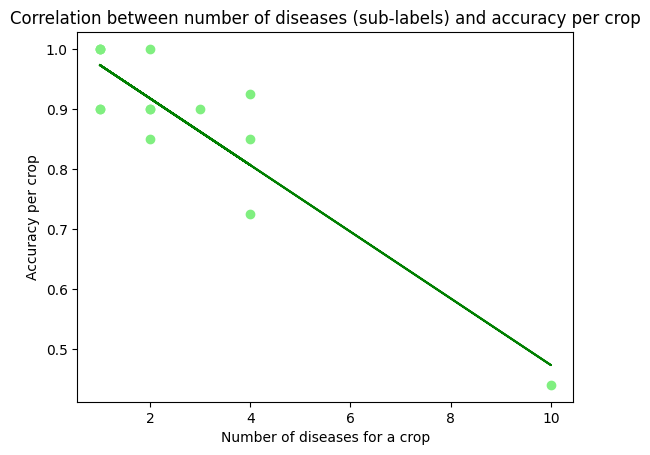

In [17]:
#analysis between number of diseases and accuracy
dict = {}
for c in names:
    crop, _ = convert_format(names.index(c))
    if crop not in dict.keys():
        dict[crop] = 1
    else:
        dict[crop] += 1
x = []
y = []
for crop in dict.keys():
    x.append(dict[crop])
    y.append(d[crop])
plt.scatter(x, y, color = '#80EF80')
slope, intercept = np.polyfit(x, y, 1)
line = [slope * i + intercept for i in x]
plt.plot(x, line, color = 'green', label = 'Best Fit Line')
plt.xlabel("Number of diseases for a crop")
plt.ylabel("Accuracy per crop")
plt.title("Correlation between number of diseases (sub-labels) and accuracy per crop")
plt.show()

This shows a clear negative correlation between the number of sub labels and the accuracy. 

### Further Exploration
#### Before & After Images
The first idea I looked at is passing in both the before and after images of the object detection, which uses a new prompt but a similar method as before. 


In [24]:
messages_train_b_a = ['Possible labels:']
grouped = df_train.groupby('class_name')
for class_id, group in grouped: 
    i = 0
    for _, row in group.iterrows():
        image_new = open(row["image_path"], "rb").read()
        image_old = open(row["image_path"].replace("processed", "preprocessed"), "rb").read()
        base64_image_n = types.Part.from_bytes(data=image_new, mime_type="image/jpeg")
        base64_image_o = types.Part.from_bytes(data=image_old, mime_type="image/jpeg")
        messages_train_b_a.append(f'Image {i} before object detection')
        messages_train_b_a.append(base64_image_o)
        messages_train_b_a.append(f'Image {i} after object detection')
        messages_train_b_a.append(base64_image_n)
        i += 0
    print(f"{class_id} done")
    messages_train_b_a.append(f"label: {class_id}")

messages_train_b_a_2 = ["Input images:"]
for i, image_path in enumerate(df_test.image_path):
    base64_img = open(image_path, "rb").read()
    base64_img_0 = open(image_path.replace("processed", "preprocessed"), "rb").read()
    image_message = [
        types.Part.from_bytes(data=base64_img_0, mime_type="image/jpeg"),
        f"input_image_id: {i}",
        f"status: before object detection",
        types.Part.from_bytes(data=base64_img, mime_type="image/jpeg"),
        f"input_image_id: {i}",
        f"status: after object detection"
    ]
    messages_train_b_a_2.extend(image_message)
    print(f"{image_path} done")
messages_train_b_a_2.append(f"Please correctly classify all {df_train.shape[0]} images")

Apple___Apple_scab done
Apple___Black_rot done
Apple___Cedar_apple_rust done
Apple___healthy done
Blueberry___healthy done
Cherry___Powdery_mildew done
Cherry___healthy done
Corn___Cercospora_leaf_spot Gray_leaf_spot done
Corn___Common_rust done
Corn___Northern_Leaf_Blight done
Corn___healthy done
Grape___Black_rot done
Grape___Esca_Black_Measles done
Grape___Leaf_blight_Isariopsis_Leaf_Spot done
Grape___healthy done
Orange___Haunglongbing_Citrus_greening done
Peach___Bacterial_spot done
Peach___healthy done
Pepper_bell___Bacterial_spot done
Pepper_bell___healthy done
Potato___Early_blight done
Potato___Late_blight done
Potato___healthy done
Raspberry___healthy done
Soybean___healthy done
Squash___Powdery_mildew done
Strawberry___Leaf_scorch done
Strawberry___healthy done
Tomato___Bacterial_spot done
Tomato___Early_blight done
Tomato___Late_blight done
Tomato___Leaf_Mold done
Tomato___Septoria_leaf_spot done
Tomato___Spider_mites_Two_spotted_spider_mite done
Tomato___Target_Spot done
T

In [25]:
client = genai.Client(api_key = API_KEY)
generation_config = types.GenerateContentConfig(response_mime_type="application/json", max_output_tokens=6000000)
CLASS_PROMPT = open("classification_prompt_before_after.txt").read()
response = client.models.generate_content(
    contents = [CLASS_PROMPT] + messages_train_b_a + messages_train_b_a_2,
    model="gemini-2.5-flash",
    config=generation_config
)

In [26]:
response_json = json.loads(response.text)
print(response_json)
predictions = [item['label'] for item in response_json['output']]
actual = list(df_test.class_name)
print("Accuracy of Before & After Technique:", get_accuracy(actual, predictions))

{'number_of_labeled_images': 380, 'output': [{'image_id': 0, 'confidence': 0.95, 'label': 'Apple___Apple_scab'}, {'image_id': 1, 'confidence': 0.93, 'label': 'Apple___Black_rot'}, {'image_id': 2, 'confidence': 0.96, 'label': 'Apple___Cedar_apple_rust'}, {'image_id': 3, 'confidence': 0.98, 'label': 'Apple___healthy'}, {'image_id': 4, 'confidence': 0.99, 'label': 'Blueberry___healthy'}, {'image_id': 5, 'confidence': 0.97, 'label': 'Cherry___Powdery_mildew'}, {'image_id': 6, 'confidence': 0.98, 'label': 'Cherry___healthy'}, {'image_id': 7, 'confidence': 0.94, 'label': 'Corn___Cercospora_leaf_spot Gray_leaf_spot'}, {'image_id': 8, 'confidence': 0.95, 'label': 'Corn___Common_rust'}, {'image_id': 9, 'confidence': 0.94, 'label': 'Corn___Northern_Leaf_Blight'}, {'image_id': 10, 'confidence': 0.99, 'label': 'Corn___healthy'}, {'image_id': 11, 'confidence': 0.96, 'label': 'Grape___Black_rot'}, {'image_id': 12, 'confidence': 0.92, 'label': 'Grape___Leaf_blight_Isariopsis_Leaf_Spot'}, {'image_id':

### Predicting Disease Given Crop Name

In [55]:
messages_train_name = ['Possible labels:']
grouped = df_train.groupby('class_name')
for class_id, group in grouped: 
    crop, disease = convert_format(names.index(class_id))
    i = 0
    for _, row in group.iterrows():
        image_new = open(row["image_path"], "rb").read()
        base64_image_n = types.Part.from_bytes(data=image_new, mime_type="image/jpeg")
        messages_train_name.append(base64_image_n)
        i += 0
    print(f"{class_id} done")
    messages_train_name.append(f"plant: {crop}")
    messages_train_name.append(f"label: {disease}")

messages_name = ["Input images:"]
for i, row in df_test.iterrows():
    crop, disease = convert_format(names.index(row["class_name"]))
    base64_img = open(row["image_path"], "rb").read()
    image_message = [
        types.Part.from_bytes(data=base64_img, mime_type="image/jpeg"),
        f"plant: {crop}"
        f"input_image_id: {i}"
    ]
    messages_name.extend(image_message)
    print(f"{image_path} done")
messages_name.append(f"Please correctly classify all {df_train.shape[0]} images")

Apple___Apple_scab done
Apple___Black_rot done
Apple___Cedar_apple_rust done
Apple___healthy done
Blueberry___healthy done
Cherry___Powdery_mildew done
Cherry___healthy done
Corn___Cercospora_leaf_spot Gray_leaf_spot done
Corn___Common_rust done
Corn___Northern_Leaf_Blight done
Corn___healthy done
Grape___Black_rot done
Grape___Esca_Black_Measles done
Grape___Leaf_blight_Isariopsis_Leaf_Spot done
Grape___healthy done
Orange___Haunglongbing_Citrus_greening done
Peach___Bacterial_spot done
Peach___healthy done
Pepper_bell___Bacterial_spot done
Pepper_bell___healthy done
Potato___Early_blight done
Potato___Late_blight done
Potato___healthy done
Raspberry___healthy done
Soybean___healthy done
Squash___Powdery_mildew done
Strawberry___Leaf_scorch done
Strawberry___healthy done
Tomato___Bacterial_spot done
Tomato___Early_blight done
Tomato___Late_blight done
Tomato___Leaf_Mold done
Tomato___Septoria_leaf_spot done
Tomato___Spider_mites_Two_spotted_spider_mite done
Tomato___Target_Spot done
T

In [61]:
client = genai.Client(api_key = API_KEY)
generation_config = types.GenerateContentConfig(response_mime_type="application/json", max_output_tokens=6000000)
CLASS_PROMPT = open("classification_prompt_given_name.txt").read()
response = client.models.generate_content(
    contents = [CLASS_PROMPT] + messages_train_b_a + messages_train_b_a_2,
    model="gemini-2.5-flash",
    config=generation_config
)

In [64]:
response_json = json.loads(response.text)
predictions = [item['label'] for item in response_json['output']]
actual = list(map(lambda x: convert_format(names.index(x))[1], df_test.class_name))
print("Accuracy of 'Given Name' Technique:", get_accuracy(actual, predictions))

Accuracy of 'Given Name' Technique: 0.8






## 5 - RAG for Treatment Predictions
This final section of the code uses a hybrid RAG to provide treatment options based on the crop and disease.

In [27]:
dataset = []
with open('preventions_database.txt', 'r') as file:
    dataset = file.readlines()
    print(f'Loaded {len(dataset)} entries')
print(dataset)

Loaded 63 entries
['To control apple scab, Prune for better air movement and sunlight penetration for drying /remove water sprouts.\n', 'To deal with apple scab in the winter, remove fallen leaves and orchard sanitation. Spray 5% solution of urea in the autumn to aid in the breakdown of leaf tissue (42 lb urea in 100 gallons of water). Since nitrogen is being applied in the orchard, the fertilizer program needs to be adjusted accordingly. Shred leaf litter using a flail mower or remove leaf litter by raking, sweeping, or vacuuming are additional options.\n', 'To prevent future apple scab, Use fungicides as appropriate.\n', 'To control black rot in apples, prune out and remove infected and dead branches in the winter when the temperature falls below 0oC. Properly dispose of infected wood away from healthy trees by burning, burying or composting. \n', 'Remove any remaining shrivelled or mummified fruit if black rot appears in apple trees. \n', 'To prevent future black rot in apple trees,

The first step here is to create a dense index using FAISS, then a sparse index using Hugging Face in BM25.

In [28]:
import faiss
from sentence_transformers import SentenceTransformer
model_faiss = SentenceTransformer('all-MiniLM-L6-v2')
vectors = model_faiss.encode(dataset)
index_d = faiss.IndexFlatL2(len(vectors[0]))
index_d.add(vectors)


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [34]:
HF_KEY = os.getenv("HUGGING_FACE_TOKEN")
from huggingface_hub import login
login(token=HF_KEY)
import bm25s
from bm25s.hf import BM25HF

retreiver = BM25HF(corpus=dataset)
retreiver.index(bm25s.tokenize(dataset))

user = "mariam-elantable"
retreiver.save_to_hub(f"{user}/bm25s-disease-prevention")

Split strings:   0%|          | 0/63 [00:00<?, ?it/s]

BM25S Count Tokens:   0%|          | 0/63 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/63 [00:00<?, ?it/s]

Finding newlines for mmindex:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  .../T/tmpedi60scv/indptr.csc.index.npy: 100%|##########| 2.12kB / 2.12kB            

  ...T/tmpedi60scv/indices.csc.index.npy: 100%|##########| 4.29kB / 4.29kB            

  ...gn/T/tmpedi60scv/data.csc.index.npy: 100%|##########| 4.29kB / 4.29kB            

No files have been modified since last commit. Skipping to prevent empty commit.


RepoUrl('https://huggingface.co/mariam-elantable/bm25s-disease-prevention', endpoint='https://huggingface.co', repo_type='model', repo_id='mariam-elantable/bm25s-disease-prevention')

Then, the query is used to retreive from the documents the top matches, which are then fed into the LLM using an augmented prompt

In [35]:
def retrieve_hybrid(query, top_n = 3, k = 50, K = 60):
    dense_embedding = model_faiss.encode([query])
    _, indices_d = index_d.search(dense_embedding, k)
    retreiver = BM25HF.load_from_hub(f"{user}/bm25s-disease-prevention", load_corpus = True)
    docs_s, _ = retreiver.retrieve(bm25s.tokenize(query), k = k)
    docs_d = [(dataset[indices_d[0][i]], i) for i in range(k)]
    docs_s = [(docs_s[0][i], i) for i in range(k)]
    sorted_docs = []
    for doc, rank in docs_d:
        score = 1.0/(K + rank)
        i = 0
        while ((i < k)):
            if (docs_s[i][0] != doc):
                i+= 1
            else:
                break

        if (i < len(docs_s)): score += 1.0/(K + i)
        sorted_docs.append((doc, score))
    sorted_docs.sort(key = lambda x: x[1], reverse = True)
    return sorted_docs[:top_n]   



In [36]:
def get_treatment(crop, disease, rag_flag = True):
    query = f"{crop} : {disease}"
    retreived_knowledge = retrieve_hybrid(query, top_n=2)
    if disease == "healthy": 
        return f"Your {crop} plant is healthy - you do not need any treatment!"

    if rag_flag:
        prompt = f'''You are a helpful chatbot. 
        Use only the following pieces of context to provide the next steps for how to take care of the following plant, which consists of the name of a plant and a disease in the format (name-disease)
        Please do not make up any information on your own. Please do not repeat yourself, make any allusion to the fact that the data is in the correct format, or act as if you are talking to someone. 
        Respond by first providing treatment mechanisms then prevention mechanisms.  
        Use only the following information:
        {'\n'.join([f' - {chunk}' for chunk, _ in retreived_knowledge])}
        '''
    else:
        prompt = f'''You are a helpful chatbot. 
        Use your knowledge base to provide the next steps for how to take care of the following plant, which consists of the name of a plant and a disease in the format (name-disease)
        Please do not repeat yourself, make any allusion to the fact that the data is in the correct format, or act as if you are talking to someone. 
        Respond by first providing treatment mechanisms then prevention mechanisms.
        '''
    LANGUAGE_MODEL = 'hf.co/bartowski/Llama-3.2-1B-Instruct-GGUF'
    stream = ollama.chat(
    model=LANGUAGE_MODEL,
    messages=[
        {'role': 'system', 'content': prompt},
        {'role': 'user', 'content': query},
    ],
    stream=True,
    )

    chat_response = ""
    for chunk in stream:
        chat_response += chunk['message']['content']
    return chat_response
    

In [37]:
def get_data(cl, confidence, rag_flag = True):
    crop, disease = convert_format(cl)
    if crop == "pepper_bell":
        crop = "bell pepper"
    string = f"The detected crop is {crop} and the detected disease is {disease}, with a confidence level of {confidence}\n{get_treatment(crop, disease, rag_flag)}"
    return string

Then, I created some comparisons of RAG vs non-RAG responses, which include the name of the disease, the confidence and the next steps.

In [38]:
print("RAG: ")
print("-"*100)
for i in response_json['output'][:1]:
    cl = names.index(i['label'])
    confidence = i['confidence']
    print(get_data(cl, confidence))
print()
print("non-RAG: ")
print("-"*100)
for i in response_json['output'][:1]:
    cl = names.index(i['label'])
    confidence = i['confidence']
    print(get_data(cl, confidence, False))


RAG: 
----------------------------------------------------------------------------------------------------


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

The detected crop is apple and the detected disease is apple scab, with a confidence level of 0.95
Here are the treatment mechanisms and prevention mechanisms for controlling Apple Scab:

**Treatment Mechanisms:**

1. **Fungicides:** Apply fungicides specifically labeled for control of Apple Scab, such as copper-based products or azoxystrobin-containing products.
2. **Copper-based products:** Copper-based fungicides can be applied to the plant canopy and soil surface to provide systemic protection against fungal diseases like Apple Scab.
3. **Resistant varieties:** Planting resistant apple varieties, such as 'Graffenreuther 124', can reduce the risk of infection.

**Prevention Mechanisms:**

1. **Pruning for better air movement and sunlight penetration:** Prune apple trees to improve air circulation and light penetration, reducing the risk of Apple Scab.
2. **Remove water sprouts:** Remove any water sprouts or weak growth that may be a source of infection by controlling soil moisture a

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

The detected crop is apple and the detected disease is apple scab, with a confidence level of 0.95
As a helpful chatbot, I'll guide you through taking care of an apple plant and addressing the issue of apple scab.

**Treatment Mechanisms:**

1. **Remove infected tissue**: Carefully remove any leaves or fruit showing signs of infection to prevent the disease from spreading.
2. **Water thoroughly**: Ensure good drainage by watering the soil deeply, but not excessively, to reduce moisture in the air that can facilitate fungal growth.
3. **Provide optimal growing conditions**: Apple plants require full sun, well-draining soil, and adequate nutrients for optimal health. Fertilize regularly, and prune trees annually to promote healthy growth.

**Prevention Mechanisms:**

1. **Remove weeds and debris**: Regularly remove weeds and debris from around the apple plant to prevent fungal spores from spreading.
2. **Monitor soil moisture**: Keep an eye on the soil's water level, ensuring it remains 

In [48]:
for path, num in enumerate(df_test['image_path']):
    print(path)
    print(num)

0
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Tomato___Early_blight/image (286).JPG
1
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Apple___Black_rot/image (617).JPG
2
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Peach___healthy/image (44).JPG
3
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Peach___healthy/image (211).JPG
4
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Corn___Common_rust/image (868).JPG
5
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Tomato___Early_blight/image (662).JPG
6
/Users/mariamelantably/Desktop/programs/vais internship/disease_project/ammended_dataset/processed/test/Tomato___Late_blight/image (119).JPG
7
/Users/mari

Finally, I ran the RAG model on all the predictions and stored them into an output file, including each image ID to be able to identify the images that were used.

In [50]:
#run RAG on all of the predictions, and store in an output file
file = open("predictions_treatments.txt", "w")
for i in response_json_1['output']:
    cl = names.index(i['label'])
    confidence = i['confidence']
    file.write(f"Image ID: {i['image_id']} \n")
    file.write(get_data(cl, confidence)+'\n')
    file.write("-"*100+'\n')
file.close()

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]